In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = 0.5
percent = 0.2

rho = 1 
res_type="primal"

num_resources = 50
num_agents = num_participants = 10

filename = "admm_resal_N%d_%.2f_n%d_m%d_%s"%(num_points, eps_sublevel, num_agents, num_resources, res_type)

In [4]:
num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

In [5]:
b_norm = 1

In [6]:
E, consensus2agent, agent2consensus, E_g = mra.resal_admm_matrices(num_agents, num_resources, A_ineq, A_all)

public_var_size = len(consensus2agent)
private_var_size = sum([agent2consensus[i].size for i in range(num_agents + 1)])
print(f"{public_var_size=}, {private_var_size=}")

public_var_size=500, private_var_size=1000


# CVXPY centralized solution

In [7]:
true_x, true_f, true_lamb  = mra.centralized_solution_resal_admm(A_all, E, A_ineq, b_ineq, E_g)
print(f"{true_f=}")

true_f=-9.69894175254799


In [8]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

2.0

In [9]:
true_x.shape, true_lamb.shape

((1000, 1), (1000, 1))

In [10]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_query_eps_o(lamb_k, z_k, i, A_all, rho,
                                                                           eps_sublevel=eps_sublevel, num_points=K, E_g=E_g)]
    fun_agents_noisy_y += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_query_noisy_price_percent(lamb_k, z_k, i, A_all, rho,
                                                                        percent=percent, num_points=K, E_g=E_g)]
    
fun_agents_eps += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_g_query_eps_o(lamb_k, z_k, A_ineq, b_ineq, E_g, rho, 
                                                                           eps_sublevel=eps_sublevel, num_points=K)]
fun_agents_noisy_y += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_g_query_noisy_price_percent(lamb_k, z_k, A_ineq, b_ineq, E_g, rho,
                                                                        percent=percent, num_points=K)]

fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# ADMM

In [11]:
K_i = num_points

In [12]:
all_results_eps, lamb_k_eps, x_k, _, mra_xk_eps  = mra.admm_consensus(fun_agents_eps, fun_obj_val, agent2consensus, consensus2agent, E, 
                                                            rho=rho, postprocessing=1, K_i=K_i, num_iters=500, 
                                                            true_f=true_f, print_freq=100, eps_res=1e-8,
                                                            res_type=res_type, history=1)


all_results_noisy_y, lamb_k_eps, x_k, _, mra_xk_noisy_y  = mra.admm_consensus(fun_agents_noisy_y, fun_obj_val, 
                                                            agent2consensus, consensus2agent, E, 
                                                            rho=rho, postprocessing=1, K_i=K_i, num_iters=500, 
                                                            true_f=true_f, print_freq=100, eps_res=1e-8,
                                                            res_type=res_type, history=1)

VIOLATION: 0.0003946498746522087, 0=
epoch=0, f_subopt_xk=3.7971E-02,  f_subopt_mra=2.4725E-01,  viol_prim_xk=7.0659E-01,  viol_prim_mra=7.0698E-01, rel_res=1.7081E+00, 1.0633E+00
epoch=100, f_subopt_xk=1.1866E-03,  f_subopt_mra=1.1897E-03,  viol_prim_xk=8.7718E-06,  viol_prim_mra=5.9726E-06, rel_res=7.6079E-03, 1.0315E-05
epoch=200, f_subopt_xk=7.9671E-04,  f_subopt_mra=7.9692E-04,  viol_prim_xk=6.7380E-06,  viol_prim_mra=6.7685E-06, rel_res=6.6176E-03, 1.0123E-06
epoch=300, f_subopt_xk=5.2543E-04,  f_subopt_mra=5.2618E-04,  viol_prim_xk=7.8442E-06,  viol_prim_mra=7.4742E-06, rel_res=4.9670E-03, 4.1932E-06
epoch=400, f_subopt_xk=3.4652E-04,  f_subopt_mra=3.4946E-04,  viol_prim_xk=7.8929E-06,  viol_prim_mra=5.1254E-06, rel_res=4.9562E-03, 8.6770E-06
epoch=499, f_subopt_xk=2.6904E-04,  f_subopt_mra=2.6999E-04,  viol_prim_xk=1.1729E-05,  viol_prim_mra=1.0299E-05, rel_res=2.8068E-03, 6.1807E-06


/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


epoch=0, f_subopt_xk=3.7972E-02,  f_subopt_mra=3.7972E-02,  viol_prim_xk=7.0659E-01,  viol_prim_mra=7.0659E-01, rel_res=1.7081E+00, 0.0000E+00
VIOLATION: 0.0003181301731521012, 1=
epoch=100, f_subopt_xk=1.1866E-03,  f_subopt_mra=1.1871E-03,  viol_prim_xk=2.5369E-05,  viol_prim_mra=1.0753E-05, rel_res=7.6257E-03, 7.5090E-05
epoch=200, f_subopt_xk=7.9699E-04,  f_subopt_mra=7.9753E-04,  viol_prim_xk=1.8976E-05,  viol_prim_mra=8.6472E-07, rel_res=6.6318E-03, 2.1750E-03
epoch=300, f_subopt_xk=5.2547E-04,  f_subopt_mra=5.3538E-04,  viol_prim_xk=1.2397E-05,  viol_prim_mra=2.8383E-06, rel_res=4.9763E-03, 8.4959E-03
epoch=400, f_subopt_xk=3.4650E-04,  f_subopt_mra=3.4837E-04,  viol_prim_xk=2.0331E-05,  viol_prim_mra=3.8256E-06, rel_res=4.9705E-03, 8.2455E-03
epoch=499, f_subopt_xk=2.6871E-04,  f_subopt_mra=2.7047E-04,  viol_prim_xk=3.2022E-05,  viol_prim_mra=4.1267E-06, rel_res=2.8358E-03, 2.3811E-03


In [13]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [14]:
T = 500

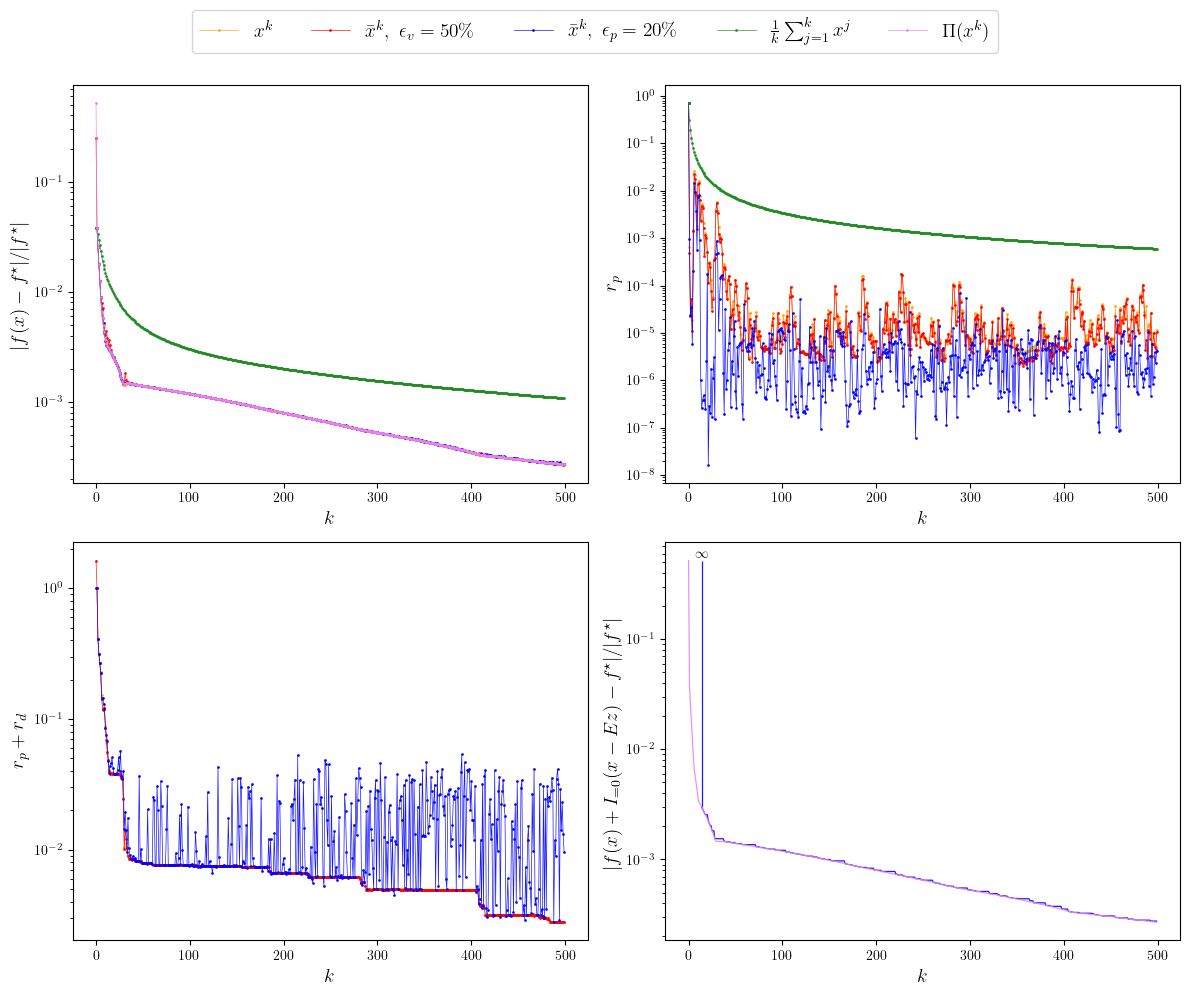

In [15]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T, admm=True)

T=500
0.0002690446407407238 sub_eps 0.00026999022719906957 noisy_y 0.0002704707132688678 proj 0.0002698419123253482


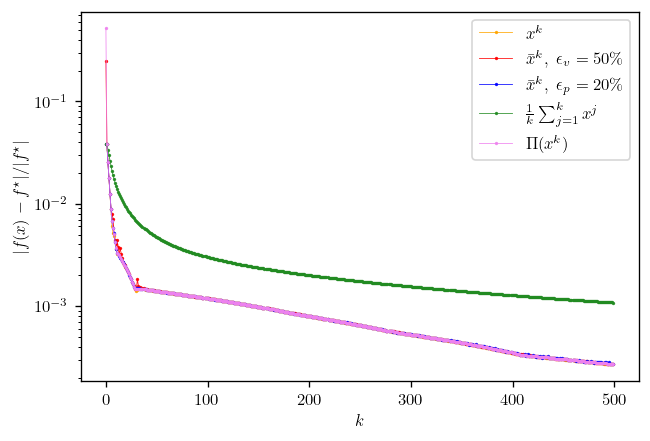

In [16]:
mra.plot_func_subopt_all(all_res, all_results_eps, all_results_noisy_y, true_f, eps_sublevel, percent, 
                        filename=filename, T=T)

In [17]:
print(np.array(all_res["viol_primal_xk"])[-1],
      "sub_eps", np.array(all_results_eps["viol_primal_mra_xk"])[-1],
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"])[-1])

1.1728733063776069e-05 sub_eps 1.0299347765212202e-05 noisy_y 4.12670664738499e-06


In [18]:
print("sub_eps", np.array(all_results_eps["viol_primal_mra_xk"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"]).size)

sub_eps 500 noisy_y 500


T=500
1.1728733063776069e-05 sub_eps 1.0299347765212202e-05 noisy_y 4.12670664738499e-06


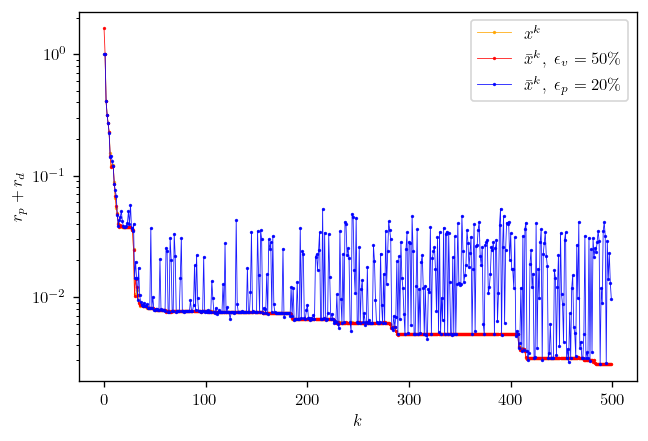

In [19]:
mra.plot_prim_complem_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                               filename=filename, T=T, admm=True)

T=500
1.1728733063776069e-05 sub_eps 1.0299347765212202e-05 noisy_y 4.12670664738499e-06


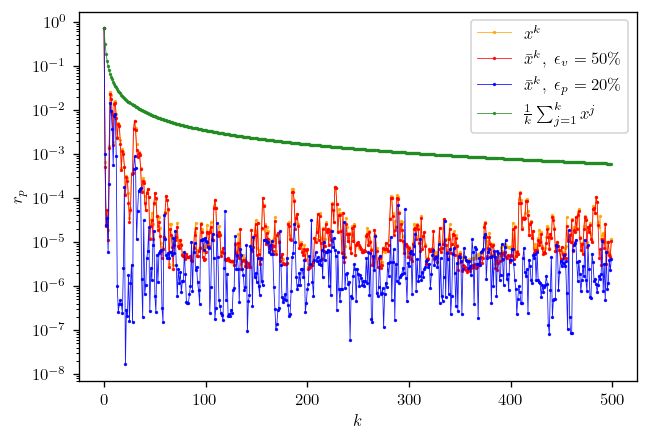

In [20]:
mra.plot_prim_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                       filename=filename, T=T, admm=True)

T=500


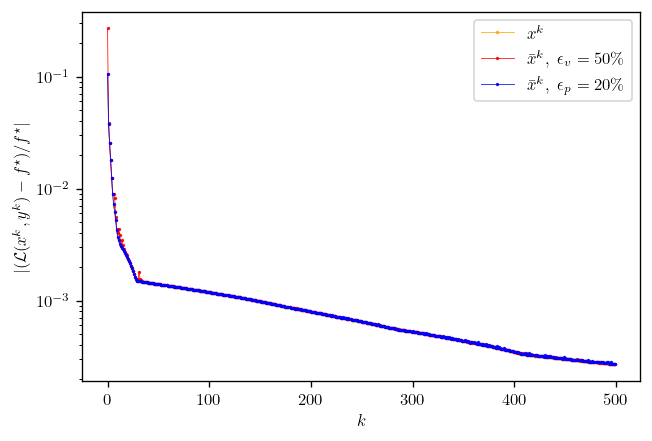

In [21]:
mra.plot_lagr_subopt_all(all_res, all_results_eps, all_results_noisy_y, eps_sublevel, percent, true_f=true_f,
                        filename=filename, T=T)

In [22]:
# T = 100
# idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
# idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
# idx_noisy_y = np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]
# idx_eps = 25#np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]

# print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

# print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
#     "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
#     "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
#     "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
#     "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

# print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
#       "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
#       "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
#       "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

In [23]:
# import pickle

# with open(f"../results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
# with open(f"../results/{filename}_dict.pkl", "rb") as file:
#     res = pickle.load(file)
